# 债券定价公式
---

## 零息债券定价
>所谓零息债券即不支付利息，到期日一次性还本的债券，债券的价值V为

$$ V = \frac{P}{(1+r)^T} $$
* V为债券当前市场价格，
* P为债券面值
* r为必要报酬率
* T为剩余到期年限

## 付息债券定价
>债券每年一次性支付利息C（元），则债券的价值V为

$$ V = \sum_{t=1}^{T} \frac{C}{(1+r)^t} + \frac{P}{(1+r)^T} $$


## 每年派息m次的债券定价
>如果每年支付的利息C按m次支付，则此债券的价值V为

$$ V = \sum_{t=1}^{mT} \frac{C/m}{(1+r/m)^t} + \frac{P}{(1+r/m)^{mT}} $$

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

sns.set(rc={'figure.figsize':(15, 5)})

In [2]:
def bond_price(par, coup_rate, r, T, freq=1):
    per_coupon = par * coup_rate / freq
    i = r / freq
    periods = freq * T
    
    discount_coupon = sum((per_coupon / (1 + i)**t for t in range(1, periods+1)))
    
    return discount_coupon + (par / (1 + i)**periods)

> 假设你买了一只50年期债券，票面利率是6%，面值是1000元，每半年付息一次。如果该债券的必要报酬率是3%，那么这个债券的价格应当是多少？

In [3]:
par = 1000
coup_rate = 6 / 100
r = 3 / 100
T = 50
freq = 2

bond_price(par, coup_rate, r, T, freq)

1774.3705550264153

# 连续复利

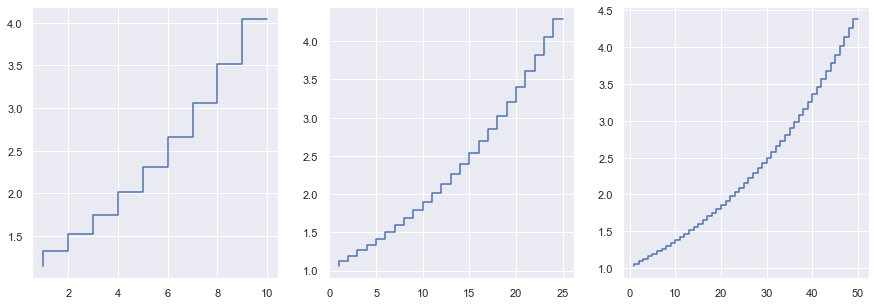

In [4]:
fig, ax = plt.subplots(1, 3)

for index, freq in enumerate([.2, .5, 1]):
    i = r / freq
    periods = freq * T
    coupon = [(1 + i) ** t for t in np.arange(1, periods+1)] 
    
    ax[index].step(np.arange(1, periods+1), coupon)

## 连续复利的零息债券定价
$$ V = \lim_{m \to \infty} \frac{P}{(1 + r/m)^{mT}} = \frac{P}{e^{rT}} $$

In [5]:
from math import exp

def zero_price_bond(par, r, T):
    return par / exp(r * T)

# Bootstrapping构建收益率曲线
---

|债券面值/元|到期时间/年|年息/元|债券价格/元|
|-|-|-|-|
|100|0.50|0|99.50|
|100|1.00|0|98.00|
|100|1.50|4（每半年付息一次）|98.50|

In [6]:
from scipy.optimize import fsolve

def func(r, par, T, price):
    return [zero_price_bond(par[i], r[i], T[i]) - price[i] for i in range(2)]

par = [100, 100]
T = [.5, 1]
price = [99.5, 98]

guess_r = [.1, .1]

spot_rates = fsolve(func, guess_r, args=(par, T, price))
spot_rates

array([0.01002508, 0.02020271])

$$ \frac{2}{e^{r_{0.5} 0.5}} + \frac{2}{e^{r_{1} 1}} + \frac{(100+2)}{e^{r_{1.5} 1.5}} = 98.5$$

In [7]:
func = lambda x: sum((2 / exp(spot_rates[i] * T[i])) 
                         for i in range(2))\
                 + 102 / exp(x * 1.5) - 98.5

spot_rates = np.append(spot_rates, fsolve(func, 0.1))
spot_rates

array([0.01002508, 0.02020271, 0.05056268])

http://www.chinamoney.com.cn/chinese/bkcurvclosedy/

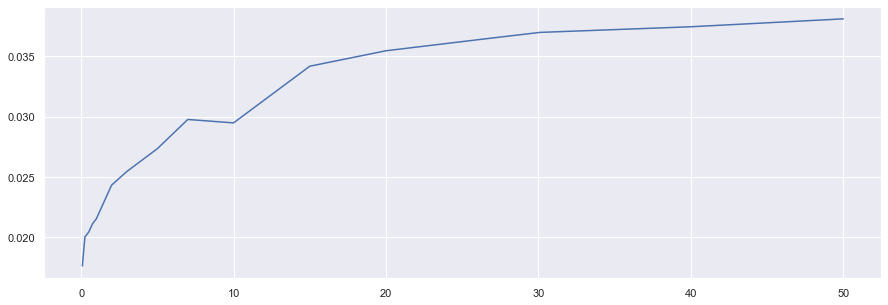

In [8]:
from bs4 import BeautifulSoup

with open('curve_data.xml', 'r') as f:
    xml = f.read()

soup = BeautifulSoup(xml, 'lxml')

x = soup.xaxis.text.split()
y = soup.graph.text.split()
spot_rates = pd.Series(y, index=x)
spot_rates.index = spot_rates.index.astype(float)
spot_rates = spot_rates.astype(float) / 100
spot_rates.plot()

## 连续复利、每年派息m次的债券定价
$$ V = \sum_{t=1}^{mT} \frac{C/m}{e^{r_{t}t/{m}}} + \frac{P}{e^{r_{T}T}}$$

In [9]:
def contcomp_price_bond(par, coup_rate, T, freq, spot_rates):
    per_coupon = par * coup_rate / freq
    periods = np.arange(1/freq, T+1/freq, 1/freq)
    
    discount_coupon = sum((per_coupon / exp(spot_rates[t] * t)
                              for t in periods))
    
    return discount_coupon + par / exp(spot_rates[T] * T)

> 假设你买了一只50年期债券，票面利率是6%，面值是1000元，每半年付息一次。那么这个债券的价格应当是多少？

In [10]:
par = 1000
coup_rate = 6 / 100
T = 50
freq = 2

contcomp_price_bond(par, coup_rate, T, freq, spot_rates)

1541.641645559535